# Cell Count EDA of Single-Cell NF1 Plate Data
This analysis focuses on describing single-cell count distributions within the NF1 feature-selected single-cell plate data.

In [1]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Find the root of the git repo on the host system

In [2]:
# Get the current working directory
cwd = pathlib.Path.cwd()

if (cwd / ".git").is_dir():
    root_dir = cwd

else:
    root_dir = None
    for parent in cwd.parents:
        if (parent / ".git").is_dir():
            root_dir = parent
            break

# Check if a Git root directory was found
if root_dir is None:
    raise FileNotFoundError("No Git root directory found.")

## Define paths

### Input paths

In [3]:
data_path = pathlib.Path(root_dir / "nf1_painting_repo/3.processing_features/data/single_cell_profiles").resolve(strict=True)

plate3df_path = pathlib.Path(data_path / "Plate_3_sc_feature_selected.parquet").resolve(strict=True)
plate3pdf_path = pathlib.Path(data_path / "Plate_3_prime_sc_feature_selected.parquet").resolve(strict=True)
plate5df_path = pathlib.Path(data_path / "Plate_5_sc_feature_selected.parquet").resolve(strict=True)

plate3df = pd.read_parquet(plate3df_path)
plate3pdf = pd.read_parquet(plate3pdf_path)
plate5df = pd.read_parquet(plate5df_path)

### Output paths

In [4]:
fig_path3 = pathlib.Path("plate_3_figures")
fig_path3p = pathlib.Path("plate_3_prime_figures")
fig_path5 = pathlib.Path("plate_5_figures")

fig_path3.mkdir(parents=True, exist_ok=True)
fig_path3p.mkdir(parents=True, exist_ok=True)
fig_path5.mkdir(parents=True, exist_ok=True)

# Map plate names to path for figure generation
plate_name_to_path_map = {
    "plate_3": fig_path3,
    "plate_3p": fig_path3p,
    "plate_5": fig_path5
}

## Processing Functions

In [5]:
cell_count_col = "Metadata_number_of_singlecells"

def agg_cell_count_to_site(_platedf):
    """
    Determine cell counts at the site level.

    Parameters
    ----------
    _platedf: Pandas Dataframe
        Single-cell morphology data for a single plate

    Returns
    -------
    site_cell_countdf: Pandas Dataframe
       Cell counts across sites with genotype and edge well columns
    """

    site_cell_countdf = (
        _platedf.groupby(["Metadata_Well", "Metadata_Site"])
        .agg(
        {
            cell_count_col: "count",
            "Metadata_genotype": get_first_element,
            "Metadata_Edge_Well": get_first_element
        })
    )

    site_cell_countdf.reset_index(inplace=True)

    return site_cell_countdf

In [6]:
def agg_cell_count_genotype_edge_well(_df):
    """
    Determine cell counts for each unique (genotype, edge well) pair.

    Parameters
    ----------
    _df: Pandas Dataframe
        Single-cell morphology data for a single plate

    Returns
    -------
    _df: Pandas Dataframe
        Number of single-cells for each unique (genotype, edge well) pair.
    """

    _df = _df.groupby(["Metadata_genotype", "Metadata_Edge_Well"]).agg(
        {
        "Metadata_number_of_singlecells": "count",
        }).reset_index()

    return _df

In [7]:
def combine_edge_well_data(_genotype_cell_countdf):
    """
    Parameters
    ----------
    _genotype_cell_countdf: Pandas Dataframe
        Single-cell morphology data aggregated to the well level with well cell counts.

    Returns
    -------
    Pandas dataframe with the well data duplicated for plotting cell count distributions.
    """

    total_well_type = _genotype_cell_countdf.groupby(["Metadata_genotype"]).agg(
        {
            "Metadata_number_of_singlecells": "sum"
        }
    ).reset_index()

    total_well_type["Metadata_Edge_Well"] = "All"

    return pd.concat([_genotype_cell_countdf, total_well_type], axis=0)

In [8]:
def set_edge_well(_well):
    """
    Parameters
    ----------
    _well: String
        The well name.

    Returns
    -------
    A string specifying the category of well {Edge Well, Inner Well}
    """

    return "Edge Well" if _well in edge_wells else "Inner Well"

In [9]:
# Custom function to retrieve the first element of metadata
def get_first_element(_pdseries):
    return _pdseries.iloc[0]

In [10]:
def calc_missing_columns_to_cells(_platedf):
    """
    Calculates the number of cells with a matching frequency of missing columns.

    Parameters
    ----------
    _platedf: Pandas Dataframe
        Single-cell morphology data for a single plate.

    Returns
    -------
    na_rows: Pandas Dataframe
        Specifies the number of cells with a matching frequency of missing columns.
        If no columns are missing by any cells, this is empty.
    """

    na_rows = _platedf.isna().sum(axis=1).value_counts()
    na_rows = na_rows.reset_index(name="Number of Cells")
    na_rows.rename(columns={"index": "Number of Missing Columns"}, inplace=True)
    na_rows.drop(0, inplace=True)

    return na_rows

## Visualization Functions

In [11]:
def visualize_missing_columns_to_cells(_platedf, _plate_name):
    """
    Visualize the number of cells with a matching frequency of missing columns in a bar plot.

    Parameters
    ----------
    _platedf: Pandas Dataframe
        Single-cell morphology data for a single plate

    _plate_name: String
        Name of the plate for labeling the data
    """

    na_rows = calc_missing_columns_to_cells(_platedf)

    if na_rows.empty:
        print("None of the cells have missing columns")

    else:
        print(na_rows)

In [12]:
def visualize_cell_counts_per_edge_wells(_edge_well_df, _plate_name):
    """
    Visualize the number of cells per edge well category and genotype in a bar plot

    Parameters
    ----------
    _edge_well_df: Pandas Dataframe
        Contains the cell count per edge well category and genotype

    _plate_name: String
        Name of the plate for labeling the data
    """
    f, ax = plt.subplots(figsize=(20, 10))

    sns.barplot(data=_edge_well_df, x="Metadata_genotype", y="Metadata_number_of_singlecells", hue="Metadata_Edge_Well")

    plt.ylabel('Well Cell Count')
    plt.xlabel('Genotype')
    plt.title('Number of cells per Genotype and Edge Well')
    plt.savefig(plate_name_to_path_map[_plate_name] / f"{_plate_name}_genotype_cell_counts_per_well_type.png")
    plt.close()

In [13]:
def visualize_cell_count_per_site(_cell_countdf, _plate_name):
    """
    Visualize the cell count in a violin plot

    Parameters
    ----------
    _cell_countdf: Pandas Dataframe
        Conatins the cell count data

    _plate_name: String
        Name of the plate for labeling the data
    """

    f, ax = plt.subplots(figsize=(20, 10))

    sns.violinplot(x=cell_count_col, y="Metadata_genotype", data=_cell_countdf)
    plt.ylabel("Genotype")
    plt.xlabel("Site Cell Count")
    plt.title("Site Cell Count for each Genotype")
    plt.savefig(plate_name_to_path_map[_plate_name] / f"{_plate_name}_violin_site_cell_counts.png")

In [14]:
def visualize_cell_count_per_edge_well_genotype(_cell_countdf, _plate_name):
    """
    Visualize the cell count in a violin plot

    Parameters
    ----------
    _cell_countdf: Pandas Dataframe
        Conatins the cell count data

    _plate_name: String
        Name of the plate for labeling the data
    """

    f, ax = plt.subplots(figsize=(20, 10))

    sns.violinplot(x=cell_count_col, y="Metadata_genotype", data=_cell_countdf)
    plt.ylabel("Genotype")
    plt.xlabel("Site Cell Count")
    plt.title("Site Cell Count for each Genotype")
    plt.savefig(plate_name_to_path_map[_plate_name] / f"{_plate_name}_violin_site_cell_counts.png")

## Visualize Number of Missing Columns

In [15]:
visualize_missing_columns_to_cells(plate3df, "plate_3")
visualize_missing_columns_to_cells(plate3df, "plate_3p")
visualize_missing_columns_to_cells(plate3df, "plate_5")

None of the cells have missing columns
None of the cells have missing columns
None of the cells have missing columns


### Specify Edge Wells

In [16]:
start_row = 'B'
end_row = 'G'

start_col = 1
end_col = 12

edge_wells = [
    f"{chr(wletter)}{wnum}" for wletter in range(ord(start_row), ord(end_row) + 1)
    for wnum in [start_col, end_col]
]

plate3df["Metadata_Edge_Well"] = plate3df["Metadata_Well"].apply(set_edge_well)
plate3pdf["Metadata_Edge_Well"] = plate3pdf["Metadata_Well"].apply(set_edge_well)
plate5df["Metadata_Edge_Well"] = plate5df["Metadata_Well"].apply(set_edge_well)

## Aggregate and Visualize Cell Counts

### Cell Counts per Site

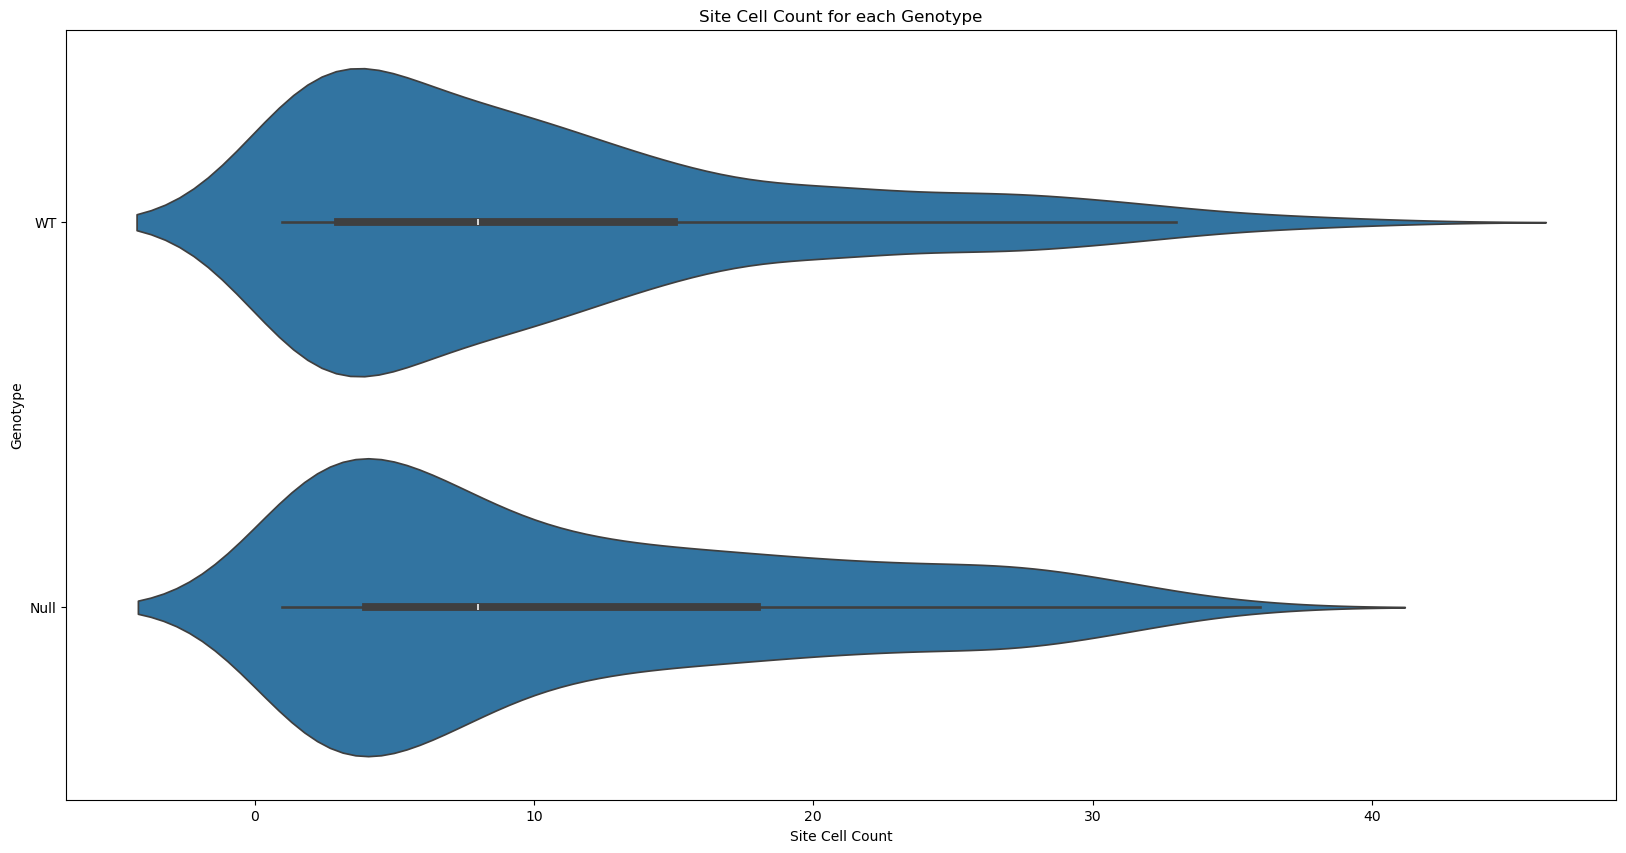

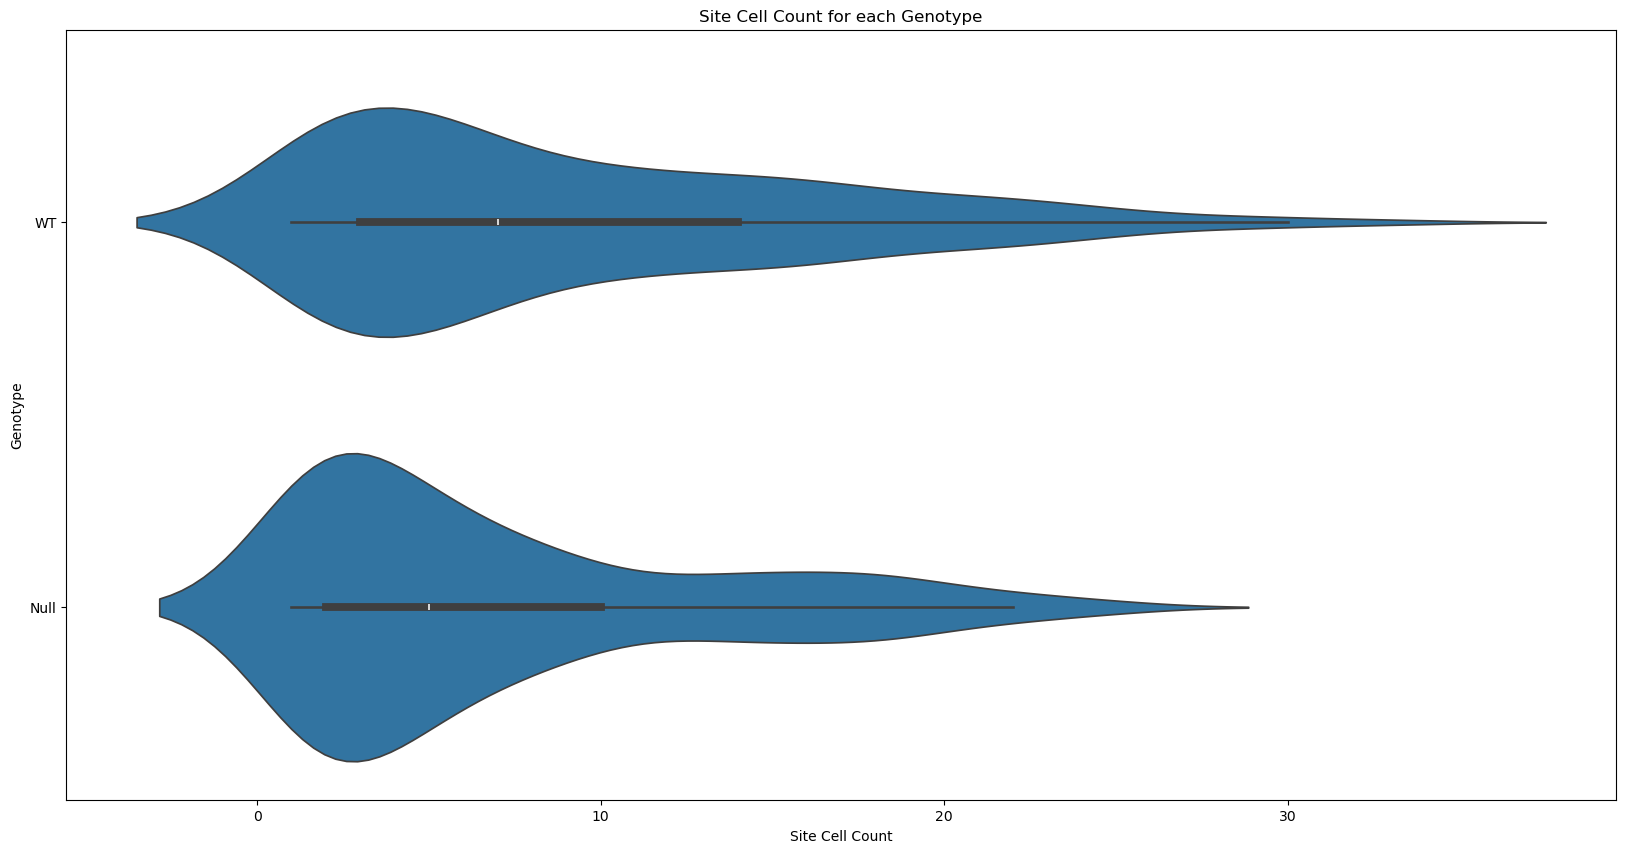

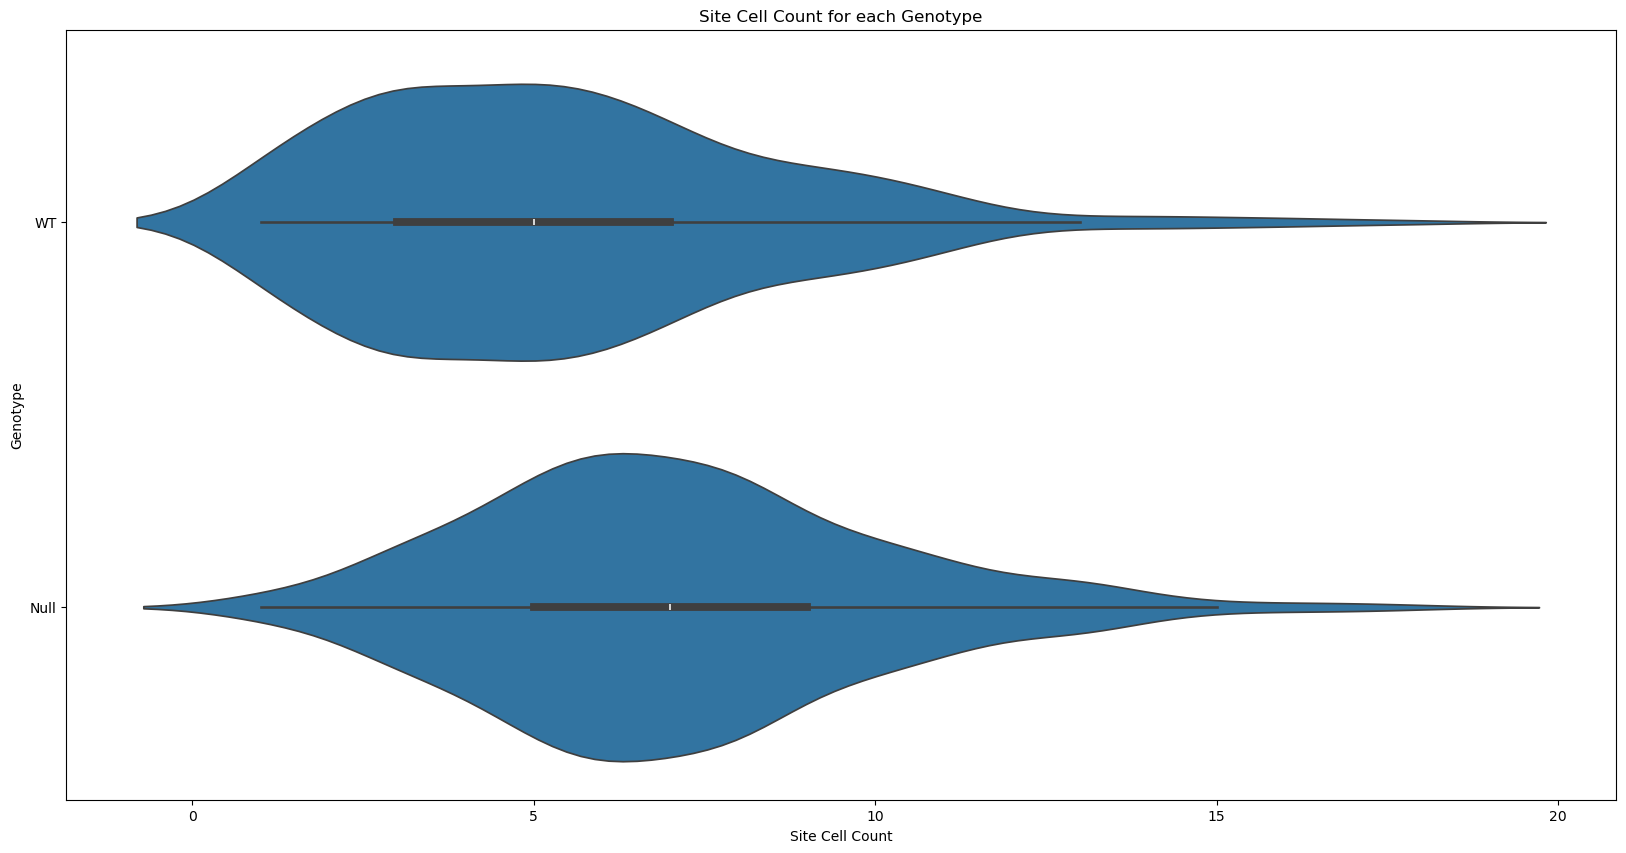

In [17]:
site_cell_count3df = agg_cell_count_to_site(plate3df)
site_cell_count3pdf = agg_cell_count_to_site(plate3pdf)
site_cell_count5df = agg_cell_count_to_site(plate5df)

visualize_cell_count_per_site(site_cell_count3df, "plate_3")
visualize_cell_count_per_site(site_cell_count3pdf, "plate_3p")
visualize_cell_count_per_site(site_cell_count5df, "plate_5")

### Cell Counts per Edge Well Category

In [18]:
genotype_cell_count3df = agg_cell_count_genotype_edge_well(plate3df)
genotype_cell_count3pdf = agg_cell_count_genotype_edge_well(plate3pdf)
genotype_cell_count5df = agg_cell_count_genotype_edge_well(plate5df)

edge_well_3df = combine_edge_well_data(genotype_cell_count3df)
edge_well_3pdf = combine_edge_well_data(genotype_cell_count3pdf)
edge_well_5df = combine_edge_well_data(genotype_cell_count5df)

visualize_cell_counts_per_edge_wells(edge_well_3df, "plate_3")
visualize_cell_counts_per_edge_wells(edge_well_3pdf, "plate_3p")
visualize_cell_counts_per_edge_wells(edge_well_5df, "plate_5")